In [76]:
# from platform import python_version

# print(python_version())

3.6.8


In [1]:
from comet_ml import Experiment

In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

Using backend: pytorch


In [2]:
import matplotlib.pyplot as plt

In [4]:
# import zipfile

# with zipfile.ZipFile('./storage/flower_graphs.zip', 'r') as zip_ref:
#     zip_ref.extractall('./storage/flower_graphs/')

## Homework 4 - Generative Models of graphs

first lets introduce our dataset, the "flower graphs" dataset


In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph)
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx]

In [4]:
graph_ds = CustomDataset('./storage/data_graphgen/flower_graphs/')

Its a pretty simple dataset, just an "inner circle" plus some short arms,
no node features or edge features

In [5]:
len(graph_ds)

64

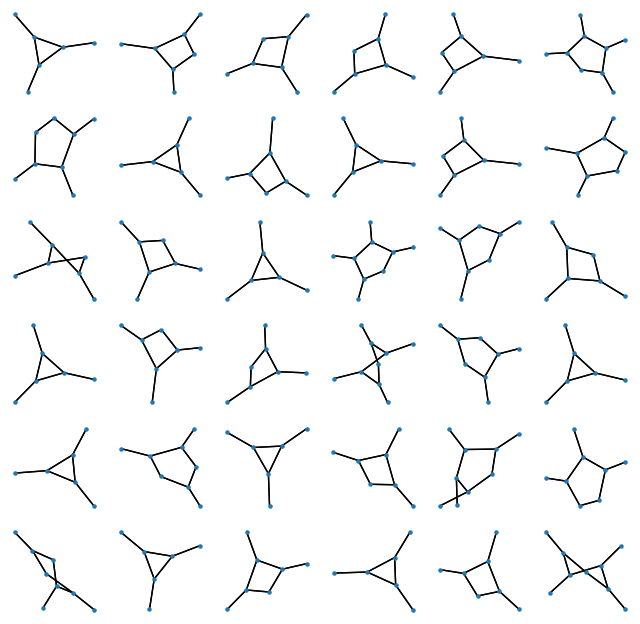

In [6]:
N = 6

fig,ax = plt.subplots(N,N,figsize=(8,8),dpi=100)


idxs = np.random.permutation(np.arange(len(graph_ds)))

for i in range(N):
    for j in range(N):
        idx = idxs[i*N+j]
        nx.draw( graph_ds[idx].to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

## your goal is to train a network that will generate graphs like these

based on what you saw in the lecture - you need to turn the graph into a sequence of "actions"

the tutorial we are following
https://docs.dgl.ai/en/0.4.x/tutorials/models/3_generative_model/5_dgmg.html

uses a sequence of integers, that represent different things based on where we are in the sequence

the function below converts a graph to a sequence in the right format

In [9]:
graph_ds[1]

DGLGraph(num_nodes=6, num_edges=12,
         ndata_schemes={}
         edata_schemes={})

In [10]:
graph_ds[1].nodes()

tensor([0, 1, 2, 3, 4, 5])

In [11]:
graph_ds[11].nodes()

tensor([0, 1, 2, 3, 4, 5, 6])

In [11]:
graph_ds[1].edges()

(tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 5]),
 tensor([1, 2, 3, 0, 2, 5, 0, 1, 4, 0, 2, 1]))

In [7]:
# convert graphs to actions
def get_decision_sequence(g):
    
    nodes = np.random.permutation( g.nodes() )
    
    edge_start, edge_end = g.edges()
    
    elist = np.random.permutation([(es,ee) for es,ee in zip(edge_start, edge_end)])
    
    added_nodes = []
    added_edges = []
    
    decision_sequence = []
    
# for node in range(len(nodes)) --albeit random perm
    for node_idx in nodes:
        
#         print('node_ix', node_idx)
        decision_sequence.append(0)  # Add node
        
        added_nodes.append(node_idx)
        
        edges_from_node = [e for e in elist if e[0]==node_idx]
#         print('edges_from_node',edges_from_node)
        for e in edges_from_node:
            
            # make sure already accounted for this node eg graph is aware of node 1 before adding edge [0,1]
            if e[1] not in added_nodes:
                continue
            # and didnt already count for reverse edge --double-edged graph?
            elif (e[1],e[0]) in added_edges:
                continue
            decision_sequence.append(0)  # Add edge
#             print('add edge',e)
#             return (e[1], added_nodes)
            # what is 0 0 
            dst = np.where(added_nodes==e[1])[0][0] #double zero indexing to access list from np.where function
            
            decision_sequence.append(dst)  # Set destination to be previous node.
            added_edges.append((e[0],e[1])) #Add -this- edge
#             print('added_edges',added_edges)
        decision_sequence.append(1)  # Stop adding edge -- how to discern bt dst 1 and stop node 1?
    decision_sequence.append(1)  # Stop adding node

    return decision_sequence


In [55]:
graph_ds[1].nodes()

tensor([0, 1, 2, 3, 4, 5])

In [56]:
graph_ds[1].edges()

(tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 5]),
 tensor([1, 2, 3, 0, 2, 5, 0, 1, 4, 0, 2, 1]))

In [57]:
# return e1, added_nodes
e1,added_nodes = get_decision_sequence(graph_ds[1])

node_ix 4
edges_from_node [array([4, 2])]
node_ix 0
edges_from_node [array([0, 1]), array([0, 3]), array([0, 2])]
node_ix 5
edges_from_node [array([5, 1])]
node_ix 2
edges_from_node [array([2, 0]), array([2, 4]), array([2, 1])]
add edge [2 0]


In [58]:
e1

0

In [59]:
added_nodes

[4, 0, 5, 2]

In [62]:
np.where(added_nodes==e1)[0][0]

1

In [14]:
# Add node (0)
# Add edge to that node (0)
# first 2 will always be 0,1 : base case add node, no edge to add
# if add edge (0), following line indicates to which node will the edge be added

# returns when decide not to add another node: last always 1
get_decision_sequence( graph_ds[5] )

[0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 4,
 0,
 5,
 0,
 0,
 1,
 0,
 0,
 5,
 1,
 1]

## after you copy-paste all the following code:

In [8]:
# copy from dgl tutorial
class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError
    
    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError
#     def forward_train(self, actions):
        
#         """
#         - actions: list
#             - Contains a_1, ..., a_T described above
#         - self.prepare_for_train()
#             - Initializes self.action_step to be 0, which will get
#               incremented by 1 every time it is called.
#             - Initializes objects recording log p(a_t|a_1,...a_{t-1})

#         Returns
#         -------
#         - self.get_log_prob(): log p(a_1, ..., a_T)
#         """
#         self.prepare_for_train()

#         stop = self.add_node_and_update(a=actions[self.action_step])
#         while not stop:
#             to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
#             while to_add_edge:
#                 self.choose_dest_and_update(a=actions[self.action_step])
#                 to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
#             stop = self.add_node_and_update(a=actions[self.action_step])

#         return self.get_log_prob()


#     def forward_inference(self):
#         """Forward at inference time.
#         It generates graphs on the fly."""
#         return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()
        
    def forward_inference(self):
        stop = self.add_node_and_update()
        while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
            num_trials = 0
            to_add_edge = self.add_edge_or_not()
            while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
                self.choose_dest_and_update()
                num_trials += 1
                to_add_edge = self.add_edge_or_not()
            stop = self.add_node_and_update()

        return self.g

    # list of actions --> forward computes likelihood of taking the sequence of actions
    # takes oracle actions as input and returns log probabilities for evaluating the loss
    def forward_train(self, actions):
        """
        - actions: list
            - Contains a_1, ..., a_T described above
        - self.prepare_for_train()
            - Initializes self.action_step to be 0, which will get
              incremented by 1 every time it is called.
            - Initializes objects recording log p(a_t|a_1,...a_{t-1})

        Returns
        -------
        - self.get_log_prob(): log p(a_1, ..., a_T)
        """
        self.prepare_for_train()

        stop = self.add_node_and_update(a=actions[self.action_step])
        while not stop:
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
            while to_add_edge:
                self.choose_dest_and_update(a=actions[self.action_step])
                to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
            stop = self.add_node_and_update(a=actions[self.action_step])

        return self.get_log_prob()


    
class GraphEmbed(nn.Module):

    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size, self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata['hv']
            return (self.node_gating(hvs) * self.node_to_graph(hvs)).sum(0, keepdim=True)
        



class GraphProp(nn.Module):

    def __init__(self, num_prop_rounds, node_hidden_size):
            super(GraphProp, self).__init__()

            self.num_prop_rounds = num_prop_rounds

            # Setting from the paper
            self.node_activation_hidden_size = 2 * node_hidden_size

            message_funcs = []
            node_update_funcs = []
            self.reduce_funcs = []

            for t in range(num_prop_rounds):
                # input being [hv, hu, xuv]
                message_funcs.append(nn.Linear(2 * node_hidden_size + 1, self.node_activation_hidden_size))

                self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
                node_update_funcs.append(nn.GRUCell(self.node_activation_hidden_size,node_hidden_size))

            self.message_funcs = nn.ModuleList(message_funcs)
            self.node_update_funcs = nn.ModuleList(node_update_funcs)
            
    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {'a': node_activation}

    def forward(self, g):
        if g.number_of_edges() > 0:
            for t in range(self.num_prop_rounds):
                g.update_all(message_func=self.dgmg_msg,
                             reduce_func=self.reduce_funcs[t])
                g.ndata['hv'] = self.node_update_funcs[t](
                     g.ndata['a'], g.ndata['hv'])


import torch.nn.functional as F
from torch.distributions import Bernoulli

def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop

class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge

from torch.distributions import Categorical

class ChooseDestAndUpdate(nn.Module):

    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])
     

In [9]:
from functools import partial
class DGMG(DGMGSkeleton):
    
    def __init__(self, v_max, node_hidden_size, num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds,node_hidden_size)

        # Actions
        # mod from 
        self.add_node_agent = AddNode(self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(self.graph_prop, node_hidden_size)

        # Forward functions
        # mod from self.forward_train = partial(forward_train, self=self), self.forward_inference = partial(forward_inference, self=self)
        self.forward_train = partial(super().forward_train)
        self.forward_inference = partial(super().forward_inference)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

    # let net define probabilities and sample from there
    def forward_inference(self):
        stop = self.add_node_and_update()
        while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
            num_trials = 0
            to_add_edge = self.add_edge_or_not()
            while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
                self.choose_dest_and_update()
                num_trials += 1
                to_add_edge = self.add_edge_or_not()
            stop = self.add_node_and_update()

        return self.g

    # list of actions --> forward computes likelihood of taking the sequence of actions
    # takes oracle actions as input and returns log probabilities for evaluating the loss
    def forward_train(self, actions):
        """
        - actions: list
            - Contains a_1, ..., a_T described above
        - self.prepare_for_train()
            - Initializes self.action_step to be 0, which will get
              incremented by 1 every time it is called.
            - Initializes objects recording log p(a_t|a_1,...a_{t-1})

        Returns
        -------
        - self.get_log_prob(): log p(a_1, ..., a_T)
        """
        self.prepare_for_train()

        stop = self.add_node_and_update(a=actions[self.action_step])
        while not stop:
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
            while to_add_edge:
                self.choose_dest_and_update(a=actions[self.action_step])
                to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
            stop = self.add_node_and_update(a=actions[self.action_step])

        return self.get_log_prob()

## you can now create a model that generates graphs

In [10]:
# v_max when not training amt 
# num_prop_rounds --to become aware of surroundings 
model = DGMG(v_max=16, node_hidden_size=10, num_prop_rounds=10)

## depending on the model being in training or evaluation mode, it will either generate a model, or evaluate the likelihood given a sequence of steps

In [96]:
model.eval();

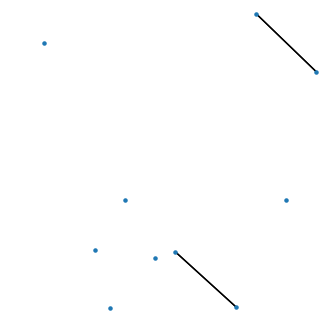

In [97]:
N = 4

fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)




for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [22]:
model.train();

In [23]:
actions = get_decision_sequence(graph_ds[5])

In [24]:
# log proba of forming this seq of actions. .exp() for readable probability -- but put in this form into model. loss=-model(actions=actions)
model(actions=actions)

tensor(-28.1646, grad_fn=<AddBackward0>)

In [ ]:
# dont need dataloader
# loop over dataself itself

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
model.train()

num_epochs = 50

loss_min = 1000

for epoch in range(50,65):
    
    epoch_loss = []
    
    for data in tqdm(graph_ds):
        
        optimizer.zero_grad()   
        
        actions = get_decision_sequence(data)
        
        loss = -model(actions=actions)
        
#         epoch_loss.append(loss.exp().item())
        epoch_loss.append(loss.item())
            
            #retain_graph?
        loss.backward(retain_graph=True)
            
        # which param for max_norm?
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        
        optimizer.step()
#         scheduler.step()
        
        
        
    print('epoch',epoch,'loss',np.array(epoch_loss).sum())
    print('avg loss',np.array(epoch_loss).mean())
    print('------------------------------------')
    
    
    if np.array(epoch_loss).sum() < loss_min:
        print('saving model..')
        torch.save(model.state_dict(),'graphgen_loss_{:.2E}.pt'.format(np.array(epoch_loss).sum()))
        loss_min = np.array(epoch_loss).sum()
        print('curr low loss',loss_min)
        print('================================')
        
        #define optimizer
        #loss optimizer
        #short training should give good model

  
        
        
        


epoch 50 loss 958.4979362487793
avg loss 14.976530253887177
------------------------------------
saving model..
curr low loss 958.4979362487793



epoch 51 loss 943.2382545471191
avg loss 14.738097727298737
------------------------------------
saving model..
curr low loss 943.2382545471191



epoch 52 loss 952.7332038879395
avg loss 14.886456310749054
------------------------------------



epoch 53 loss 939.9126558303833
avg loss 14.686135247349739
------------------------------------
saving model..
curr low loss 939.9126558303833



epoch 54 loss 961.1123809814453
avg loss 15.017380952835083
------------------------------------



epoch 55 loss 919.3823089599609
avg loss 14.36534857749939
------------------------------------
saving model..
curr low loss 919.3823089599609



epoch 56 loss 922.7385721206665
avg loss 14.417790189385414
------------------------------------



epoch 57 loss 941.9507069587708
avg loss 14.717979796230793
------------------------------------



epoch 58 loss 929.475555896759
avg loss 14.52305556088686
------------------------------------



epoch 59 loss 938.2072772979736
avg loss 14.659488707780838
------------------------------------



epoch 60 loss 914.8993954658508
avg loss 14.29530305415392
------------------------------------
saving model..
curr low loss 914.8993954658508



epoch 61 loss 932.8979330062866
avg loss 14.576530203223228
------------------------------------



epoch 62 loss 937.4645276069641
avg loss 14.647883243858814
------------------------------------



epoch 63 loss 928.879919052124
avg loss 14.513748735189438
------------------------------------



epoch 64 loss 932.4494352340698
avg loss 14.569522425532341
------------------------------------


## submit the trained model source code + saved state_dict 

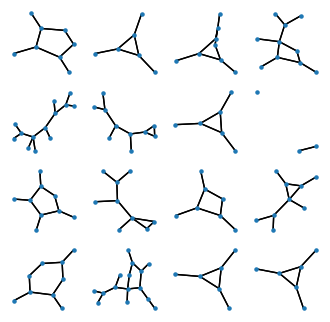

In [15]:
# graphgen_loss_9.32E+02.pt
N = 4
model.eval()
fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)


for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [18]:
net = DGMG(v_max=16, node_hidden_size=10, num_prop_rounds=10)
net.load_state_dict(torch.load('graphgen_loss_9.15E+02.pt'))

<All keys matched successfully>

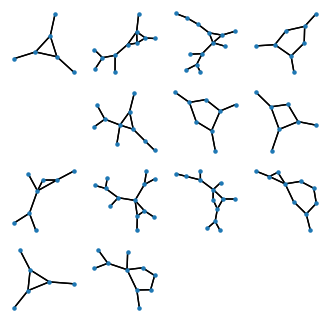

In [19]:
# graphgen_loss_9.15E+02.pt
N = 4
model.eval()
fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)


for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [16]:

torch.save(model.state_dict(),'graphgen_loss_{:.2E}.pt'.format(np.array(epoch_loss).sum()))